# MNIST 데이터 세트 다운로드

mnist 데이터 세트 다운로드

In [34]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False) # 본문에는 as_frame 생략

사이킷런 데이터 세트의 키

In [35]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


mnist 데이터 세트의 모양

In [36]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


X\[0\] 이미지

<class 'numpy.ndarray'>


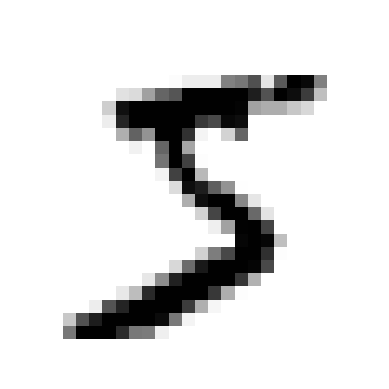

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt

print(type(X))
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

y\[0\] 레이블

In [38]:
y[0]

'5'

대부분의 머신러닝 알고리즘은 레이블을 숫자로 기대하므로 y를 정수로 변환

In [39]:
import numpy as np

y = y.astype(np.uint8)
y[0]

np.uint8(5)

데이터 세트를 훈련 세트와 테스트 세트로 분링

항상 데이터를 자세히 조사하기 전에 테스트 세트를 만들고 따로 떼어놓아야 한다. 2장에서 언급한 데이터 스누핑이 발생할 수 있기 때문이다.

MNIST 데이터 세트는 앞 60000개는 훈련 세트, 그 다음 나머지 10000개는 테스트 세트로 이미 나누어져 있어 테스트 세트를 따로 떼어놓기 쉽다. 또한 MNIST 훈련 세트는 이미 섞여 있어 모든 교차 검증 폴드를 비슷하게 만든다(교차 검증 폴드의 알고리즘을 몰라서 왜 그렇게 되는지는 모름, 굳이 알 필요가 있나 싶기도 함).

In [40]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기

In [41]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

참고로, 확률적 경사 하강법 분류기는 매우 큰 데이터 세트라고 할지라도 학습할 수 있다.  
또한, SGDClassifier는 한 번에 하나씩 훈련 샘플을 독립적으로 처리하므로 한 번 학습할 때의 속도가 매우 빠르다.

In [42]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [43]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

위에서 학습한 확률적 경사 하강법 분류기(sgd_clf)로 성능을 측정한다.

분류기 모델은 회귀 모델보다 성능 평가가 훨씬 어렵다.

## 교차 검증을 사용한 정확도 측정

정확도 측정을 하고 (**더 많은 제어**를 하기 위해 )교차 검증 **직접 구현**

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


cross_val_score 함수로 교차 검증 구현

In [45]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

'5 아님' 클래스로 분류하는 더미 분류기

In [46]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [47]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면, 정확도가 90%임. 위 예와 같이 이진 분류기에 사용된 데이터 세트는는 5가 아닌 클래스의 개수가 90%로 매우 불균형한 데이터 세트임.  
  
따라서, **정확도는 분류기의 성능 측정 지표로 선호되지 않음.** 특히, 어떤 클래스가 다른 클래스보다 월등히 많은 **불균형한 데이터 세트에서는 더 선호되지 않음**.

## 오차 행렬

cross_val_predict는 각 폴드에서 테스트 데이터를 예측한 후 예측된 값들을 모아서 반환함.

cross_val_predict는 샘플에 대해 **깨끗한 예측**을 함(훈련하는 동안 보지 못했던 데이터를 예측)

In [48]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix는 실제 클래스(행)를 어떤 클래스(열)로 예측했는지 나타내는 행렬임.

confusion_matrix을 이용해 TP, FN, TN, FP를 구한 후 이들을 가지고 분석에 사용되는 점수(score)들을 계산한다.  
  
| 점수       | 다른 이름                                           | 값                                                                                         | 설명                                  |
| -------- | ----------------------------------------------- | ----------------------------------------------------------------------------------------- | ----------------------------------- |
| 정확도      | Accuracy, ACC                                   | $\frac{TP+TN}{TP + TN + FP + FN}$                                                         | 전체 샘플들 중에서 정답으로 예측된 샘플들의 비율이다.      |
| 정밀도      | Precision, P, PPV, Positive Predictive Value    | $\frac{TP}{TP + FP}$                                                                      | 긍정으로 예측된 샘플들 중에서 실제로 긍정인 샘플들의 비율이다. |
| 재현율, 민감도 | Sensitivity, Recall, R, TPR, True Positive Rate | $\frac{TP}{TP + FN}$                                                                      | 실제로 긍정인 샘플들 중에서 긍정으로 예측된 샘플들의 비율이다. |
| 특이도      | Specificity, S, TNR, True Negative Rate         | $\frac{TN}{TN + FP}$                                                                      | 실제로 부정인 샘플들 중에서 부정으로 예측된 샘플들의 비율이다. |
| $F_1$ 점수 | $F_1$ Score                                     | $\frac{2}{\frac{1}{P} + \frac{1}{R}} = \frac{2PR}{P+R} = \frac{TP}{TP + \frac{FN+FP}{2}}$ | 정밀도와 재현율의 조화 평균이다.                  |


이진 클래스가 아닌 다중 클래스일 경우 이들을 계산할 때 average 속성으로 어떻게 계산할지 정할 수 있다.  
  
| average 속성 | 설명                                                                                                                    |     |
| ---------- | --------------------------------------------------------------------------------------------------------------------- | --- |
| None       | 각 클래스별로 점수를 계산한 값들을 출력한다.                                                                                             |     |
| micro      | 각 클래스별로 점수를 계산하고 이를 산술 평균한 값을 출력한다.                                                                                   |     |
| macro      | 클래스마다 TP, FN, TN, FP를 모두 구한 후 모든 클래스에 걸쳐 TP, FN, TN, FP를 더하여 전체 TP, FN, TN, FP를 구한다. 그리고 구해진 이 값들을 이용한 점수를 계산하여 출력한다. |     |
| weighted   | 각 클래스별로 점수를 계산하고 이를 클래스 비율로 가중 평균한 값을 출력한다.                                                                           |     |

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

이제 혼동 행렬을 이용하여 계산된 점수들로 $F_1$ 점수, AUPR, AUROC 등과 같은 **성능 지표**를 계산할 수 있다.

## 정밀도와 재현율

성능 지표로 활용되는 정밀도와 재현율을 계산해보았을 때 정확도만큼 좋은 성능이 나오지 않는다.

In [50]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


$F_1$ Score는 정밀도와 재현율의 조화 평균으로 정밀도와 재현율을 고려한 대표값으로 사용된다.

산술 평균은 더 큰 값에 더 큰 가중치를 두고, 기하 평균은 더 작은 값에 더 낮은 가중치를 두는 반면, 조화 평균은 값에 상관없이 동일한 가중치를 둔다. 이를 일반화한 가중 조화 평균이 있는데 각 값에 서로 다른 가중치를 줄 수 있다.  
  
> [Harmonic Mean](https://corporatefinanceinstitute.com/resources/data-science/harmonic-mean/)  
> It is the most appropriate measure for ratios and rates because **it equalizes the weights of each data point**. For instance, **the arithmetic mean places a high weight on large data points**, while **the geometric mean gives a lower weight to the smaller data points**.

In [51]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


$F_1$ Score가 높다고 해서 항상 좋은 것만은 아니다.

안전한 동영상을 걸러내는 분류기는 재현율이 낮더라도 정밀도가 더 중요하고,  
감시 카메라를 통해 좀도둑을 잡아내는 분류기는 정밀도가 낮더라도 재현율이 더 중요하다.  
이 경우 일반화된 $F_1$ Score를 사용하면 좋다. $F_1$ Score는 가중 조화 평균을 사용하여 값에 가중치를 다르게 부여할 수 있다.

하지만 정밀도를 높이면 재현율은 낮아지고, 재현율을 높이면 정밀도가 낮아진다. 이를 '정밀도/재현율 트레이드 오프'라고 한다.

## 정밀도/재현율 트레이드오프

decision_function() 함수는 샘플의 결정 함수를 반환한다.  
결정 함수는 샘플이 초평면으로 부터 얼마나 떨어져 있는지, 어느 방향으로 떨어져 있는지 알려준다.

In [52]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

threshold는 임계값으로 이 값을 기준으로 크면 양성으로 작으면 음성으로 분류가 된다.  
decision_function() 함수로 모든 샘플의 초평면으로부터의 부호 있는 거리를 구한 후, 이 거리들을 threshold를 기준으로 분류한다.

In [53]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [54]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [55]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

### 임계값에 따른 정밀도와 재현율(PR) 그래프

'임계값에 정밀도와 재현율 그래프'는 '정밀도/재현율 트레이드 오프'를 가시적으로 이해시켜주기도 하지만, 적절한 임계값을 정할 때도 도움을 준다.

이 경우, 재현율은 임계값이 증가할 때마다 감소하는 건 당연한 건데, 정밀도는 임계값이 증가할 때마다 증가하기만 하는 것이 아니고 감소하기도 하고 증가하기도 하므로 그래프가 들쭉날쭉하다.  

precision_recall_curve나 이후에 등장할 roc_curve는 불리언 속성 **drop_intermediate**을 통해 thresholds의 개수를 정할 수 있다.

drop_intermediate가 False라면 thresholds가 y_scores와 같고, drop_intermediate가 True라면 자동으로 더 적은 수의 적당한 thresholds를 지정한다.

In [56]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

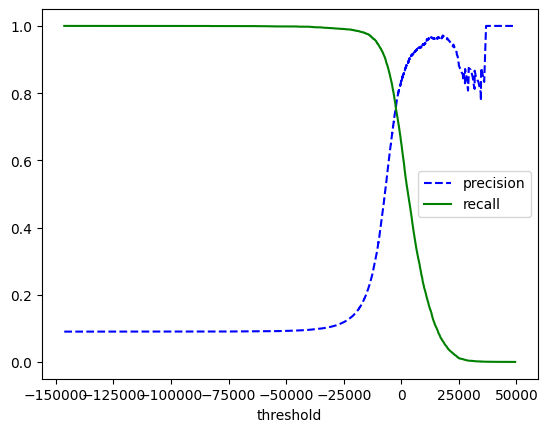

In [57]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    
    plt.legend()
    plt.xlabel("threshold")
    
plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.show()

### 정밀도, 재현율(PR) 그래프

정밀도, 재현율 그래프도 역시 적절한 임계값을 정할 때 도움을 준다.  
보통 아래 그래프에서 갑자기 하강하는 지점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.  
이 경우 recall이 0.75일 때의 threshold보다 더 작은 값으로 threshold를 선택하면 적합하다.

하지만, 절대적인 기준은 아니고 프로젝트마다 정밀도/재현율 트레이드오프 기준이 다르다.

average_precision_score() 함수를 사용하면 PR 곡선의 아래 면적인 AUPR(PR 곡선의 AUC)을 구할 수 있어, 서로 다른 모델을 비교하는 데 도움이 된다.

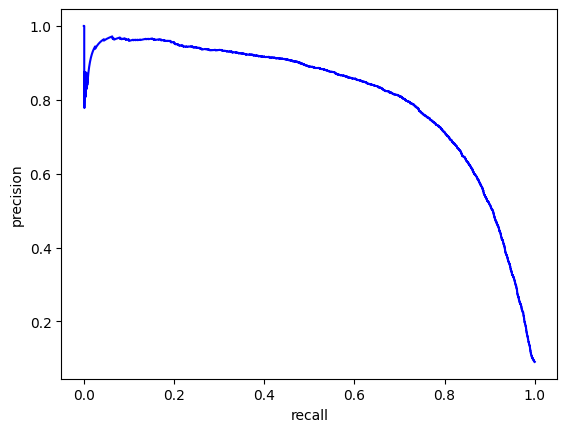

In [58]:
plt.plot(recalls, precisions, "b-")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

정밀도 90% 달성을 목표

In [59]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.019499144183)

정밀도 90% 달성을 위한 (훈련 세트에 대한) 예측을 만들려면 분류기의 predict() 메서드를 호출하는 것 대신 **아래의 코드를 실행**하면 된다.

In [60]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [61]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## ROC 곡선

ROC(수신기 조작 특성, receiver operating characteristic)는 이진 분류에서 널리 사용되는 성능 평가 도구이다.

roc_curve() 함수를 통해 ROC 곡선을 그릴 때 필요한 FPR, TPR, threshold을 일괄적으로 계산할 수 있다.

FPR은 거짓 양성 비율을 의미하는데 1-TNR(특이도)와 값이 같다.  
TPR은 진짜 양성 비율을 의미하는데 민감도, 재현율라고도 불린다.

threshold가 100%에서 0%에 가까워짐에 따라 TPR과 FPR도 항상 증가하므로 ROC 그래프는 증가함수이다. 

그래프가 perfect classifier에 가까울수록 좋은 모델이다.  

random classifier인 경우에 클래스 비율에 따라 무작위로 예측한다. 이렇게 되면 오차 행렬의 실제 클래스가 비슷한 비율의 예측 클래스로 나뉘어 FPR과 TPR 값이 비슷해진다. 결국 ROC 곡선이 y=x에 가깝게 되어 AUROC 면적이 0.5가 된다.  
  
DummyClassifier에서 랜덤 분류기를 제공한다.

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

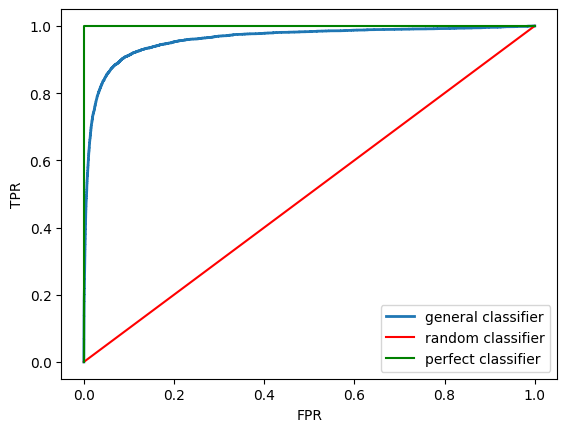

In [63]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'r-', label="random classifier")
    plt.plot([0,0, 0,1], [0,1, 1,1], 'g-', label="perfect classifier")
    plt.plot
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    
plot_roc_curve(fpr, tpr, "general classifier")
plt.show()

AUC 계산

roc_auc_score() 함수를 사용하면 ROC의 아래 면적인 AUROC(ROC의 AUC)를 구할 수 있어, 서로 다른 모델을 비교하는 데 도움이 된다.  
perfect classifier의 경우 AUROC가 1이고, random classifier의 경우 AUROC가 0.5이다. general classifier의 경우 보통 AUROC $\in (0.5, 1)$ 이다.

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

RandomForestClassifier ROC 곡선

In [65]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

양성 클래스 확률을 점수로 사용

보통 roc_curve나 precision_recall_curve를 그릴 때 decision_function의 반환값인 decision이나 predict_proba의 반환값인 확률을 사용한다.

RandomForestClassifier는 predict_proba의 반환값인 확률을 사용한다.

In [66]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5,y_scores_forest)

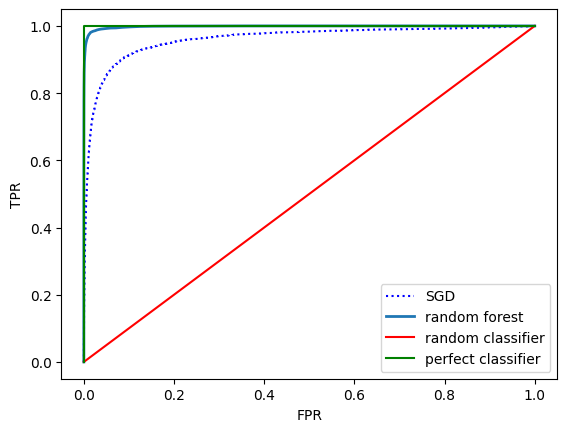

In [67]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="random forest")
plt.legend(loc="lower right")
plt.show()

In [68]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983296721818179)

가장 중요한 것은 PR 곡선과 ROC 곡선을 통해 분석하는 것이다.

PR 곡선과 ROC 곡선을 살펴보았는데 데이터의 두 클래스의 데이터의 분포와 threshold가 100%에서 0%까지 가는 움직임을 보고 PR 곡선과 ROC 곡선을 그릴 수 있어야 하고, PR 곡선과 ROC 곡선을 보고 데이터의 분포를 파악할 수 있어야 한다.

참조  
[ROC 곡선과 PR 곡선1](https://nanunzoey.tistory.com/entry/ROC-곡선-vs-P-R-곡선)  
[ROC 곡선과 PR 곡선2](https://ichi.pro/ko/roc-mich-precision-recall-gogseon-213574150750732)

# 다중 (클래스) 분류기, 다항 분류기

다중 분류기(multiclass classifier) 혹은 다항 분류기(multinomial classifier)는 2개 이상의 클래스를 분류하는 분류기를 말한다.

'SGD 분류기', '랜덤 포레스트 분류기', '나이브 베이즈 분류기'와 같은 알고리즘은 2개 이상의 클래스를 분류할 수 있지만, '로지스틱 회귀', '서포트 벡터 머신'과 같은 알고리즘은 2개의 클래스만 분류할 수 있다.

하지만 여러 개의 이진 분류기를 사용해 다중 분류기를 만들 수 있다.  
  
클래스 개수 만큼의 이진 분류기를 가지고 같은 샘플을 분류한 후 결정 점수가 가장 높은 클래스를 최종적으로 분류될 클래스로 선택하는 OvR(one-versus-the-rest), OvA(one_versus-all) 전략을 사용할 수 있다.  
  
클래스 조합의 개수 만큼의 이진 분류기를 가지고 같은 샘플을 분류한 후 가장 많이 양성으로 분류된 클래스를 최종적으로 분류될 클래스로 선택하는 OvO(one-versus-one) 전략을 사용할 수도 있다.

참고로 OvR에서 언급한 결정 점수(신뢰 점수, confidence score)는 양수라면 양성이고 음수라면 음성이다. 결정 점수의 크기(초평면으로부터의 거리)가 클수록 해당 클래스일 가능성이 높다.  
OvR은 분류기마다 훈련 세트 전체가 필요하지만, OvO는 분류기마다 훈련 세트 중 해당 분류기로 분류될 2개의 클래스에 속하는 샘플만 필요하다.

서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 적은 분류기들을 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기들을 훈련시키는 것이 빠르므로 OvO를 선호한다.  
하지만 대부분의 이진 분류 알고리즘은 OvR을 선호한다.

이진 분류기인 서포트 벡터 머신(분류, SVC)에 다중 클래스 분류 작업(숫자를 분류하는 것)을 할당하면 **자동으로 OvO 전략**을 적용한다

2분 47초 소요

In [69]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [58]:
np.argmax(some_digit_scores)

np.int64(5)

In [59]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

사이킷런에서 OneVsOneClassifier나 OneVsRestClassifier를 사용하면 OvO나 OvR 방식을 강제할 수 있다.  
예를 들어, `OneVsRestClassifier(SVC())`와 같이 사용하면 된다.

서포트 벡터 머신(SVC)에 자동으로 OvO 전략을 적용하지 않고 **수동으로 OvR 전략을 적용**한다.

10분 11초 소요, OvO보다 4배 더 느림

In [60]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

In [79]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [80]:
len(ovr_clf.estimators_)

10

SGDClassifier나 RandomForestClassifier와 같은 다중 클래스 분류기를 훈련시키는 것도 가능하다.

In [81]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [82]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [83]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

교차 검증으로 평가

In [84]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

입력 스케일을 조정하여 성능(정확도)를 높힐 수도 있다.

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

교차 검증으로 예측을 만듦

In [74]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

오차 행렬을 리스트로 출력

In [75]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

오차 행렬을 이미지로 출력

어두운 부분은 이미지가 적거나, 분류기가 해당 숫자를 잘 분류하지 못한다는 뜻이다. 이 두 경우를 모두 확인해야 함.

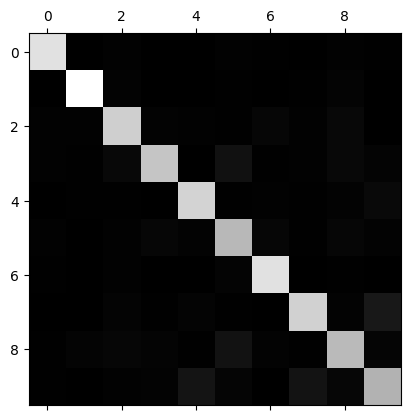

In [76]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

에러의 비율 확인

제대로 예측한 부분은 모두 검은색으로 만듦.  

각 값을 클래스의 전체 샘플 개수로 나누어 에러 비율을 비교한다.  
에러 개수를 비교할 경우 클래스의 전체 샘플 개수가 많을수록 에러가 많아 보인다.

여기서 하얀색으로 나타나는 부분은 모두 에러이므로  
**하얀색 부분이 많은 열에 해당하는 숫자로 잘못 분류될 확률이 높다**는 것을 알 수 있다.

In [77]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

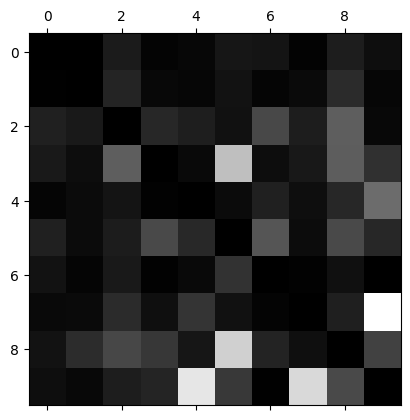

In [78]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.  
예를 들어, 오차 행렬을 보았을 때 8로 잘못 분류되는 경우가 꽤 존재하므로  
8처럼 보이지만 8이 아닌 훈련 데이터를 더 많이 모아서 실제 8과 구분이 되도록 훈련시킬 수 있다.

또, 오차 행렬을 분석하면 분류기에 도움이 될 만한 특성을 더 찾아볼 수도 있다.  
동심원의 수를 세는 알고리즘을 통해 동심원의 수를 특성으로 추가할 수 있다.  
어떤 패턴이 드러나도록 이미지 전처리를 할 수도 있다.

**개개의 에러를 분석**해보면 분류기가 무슨 일은 하는지, 왜 잘못되었는지에 대해 통찰을 얻을 수 있다. 예를 들어, 3와 5를 서로로 잘못 분류하는 것에 대한 통찰을 얻을 수 있는 코드가 아래에 있다.  
또, 이 통찰을 기반으로 분류기의 성능이 향상될 수 있는 아이디어를 얻을 수 있다. 예를 들어, 이미지의 전처리, 모델의 변경 등이 있다.

In [102]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

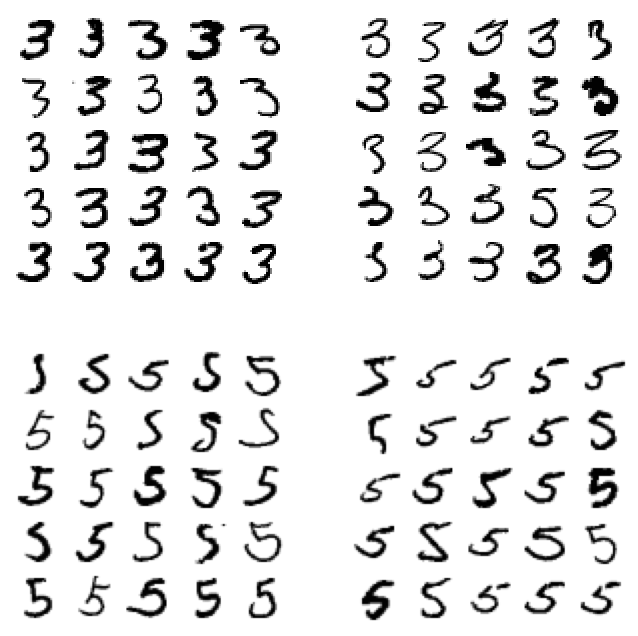

In [104]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 다중 레이블 분류

다중 레이블 분류기(multilabel classifier)는 정답에 2개 이상의 레이블이 있고 각 레이블에 양성 클래스와 음성 클래스만 있는 샘플을 분류하는 분류기이다.

In [106]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [107]:
knn_clf.predict([some_digit]) # 5 예측

array([[False,  True]])

In [131]:
knn_clf.predict([X_train[np.where(y_train == 7)[0][0]]]) # 7 예측

array([[ True,  True]])

In [108]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [109]:
f1_score(y_multilabel, y_train_knn_pred, average="macro") # macro는 산술 평균

np.float64(0.9764102655606048)

# 다중 출력 분류, 다중 출력 다중 클래스 분류

다중 출력 다중 클래스 분류기(multioutput-multiclass classifier) 혹은 다중 출력 분류기(multioutput classifier)는 정답에 2개 이상의 레이블이 있고 각 레이블에 2개 이상의 클래스가 있는 샘플을 분류하는 분류기이다. 다중 레이블 분류기를 일반화한 모델이다.

In [143]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0

In [144]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [150]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

예측 전 샘플

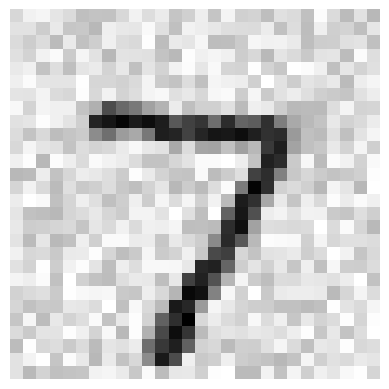

In [151]:
plot_digit(X_test_mod[some_index])

예측된 샘플

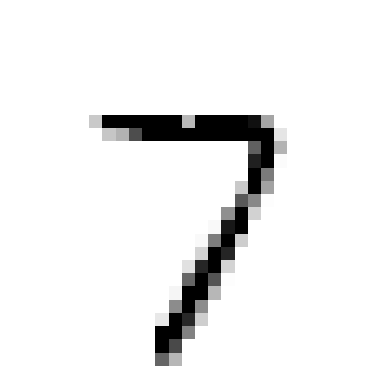

In [154]:
plot_digit(clean_digit)

샘플 정답

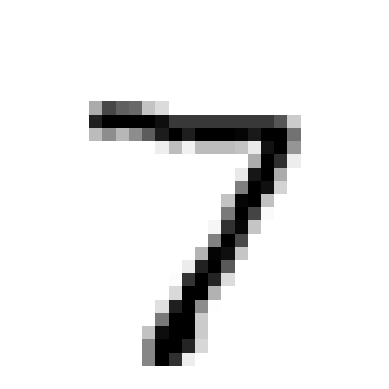

In [155]:
plot_digit(y_test_mod[some_index])